#🏥Hospital Admmissions Data EDA

Integrantes:
*   Martina Gonzalez
*   Raquel Rehbein




Preguntas de investigación
🔹 Clasificación

¿Podemos predecir si un paciente hospitalizado por una enfermedad cardiovascular fallecerá o será dado de alta, en función de sus características clínicas, demográficas y comorbilidades?

📘 Objetivo del modelo: predecir el desenlace hospitalario (OUTCOME: alta = 0 / fallecido = 1).

🔹 Regresión

¿Podemos estimar cuántos días permanecerá hospitalizado un paciente, considerando sus condiciones clínicas, demográficas y de ingreso?

📘 Objetivo del modelo: predecir la duración de la estancia hospitalaria (DURATION OF STAY, variable continua).

https://www.kaggle.com/datasets/ashishsahani/hospital-admissions-data

###Importar librerias y cargar datos

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [3]:
from google.colab import files
import pandas as pd

# Subir primer archivo admission
uploaded = files.upload()
df_adm = pd.read_csv(next(iter(uploaded)), sep=",", encoding="latin-1")

# Subir segundo archivo mortality
uploaded = files.upload()
df_mor = pd.read_csv(next(iter(uploaded)), sep=",", encoding="latin-1")

# Subir tercer archivo pollution
uploaded = files.upload()
df_pol = pd.read_csv(next(iter(uploaded)), sep=",", encoding="latin-1")


Saving HDHI Admission data.csv to HDHI Admission data.csv


Saving HDHI Mortality Data.csv to HDHI Mortality Data.csv


Saving HDHI Pollution Data.csv to HDHI Pollution Data.csv


###Revisión general

# 3️⃣Preparación de los datos

###Limpieza

In [17]:
#limpieza de caracteres extraños, munisculas, uso de guion bajo en vez de espacios
def clean_columns(df):
    df.columns = df.columns.str.replace('ï»¿','').str.strip().str.lower().str.replace(" ", "_")
    return df

df_adm = clean_columns(df_adm)
df_mor = clean_columns(df_mor)
df_pol = clean_columns(df_pol)


In [18]:
# Convertir columnas de fecha
df_adm['d.o.a'] = pd.to_datetime(df_adm['d.o.a'], errors='coerce')
df_adm['d.o.d'] = pd.to_datetime(df_adm['d.o.d'], errors='coerce')
df_mor['date_of_brought_dead'] = pd.to_datetime(df_mor['date_of_brought_dead'], errors='coerce')
df_pol['date'] = pd.to_datetime(df_pol['date'], errors='coerce')

# renombrar columnas para mayor comprension
df_adm.rename(columns={'d.o.a':'date_of_admission', 'd.o.d':'date_of_discharge'}, inplace=True)

In [19]:
#conversion de columnas numericas que aparecian como tipo object
for col in ['hb','tlc','platelets','glucose','urea','creatinine','bnp','ef']:
    if col in df_adm.columns:
        df_adm[col] = pd.to_numeric(df_adm[col], errors='coerce')

for col in ['pm10_max','no2_max','ozone_max']:
    if col in df_pol.columns:
        df_pol[col] = pd.to_numeric(df_pol[col], errors='coerce')


Antes de tratar valores nulos, analizamos las columnas

In [20]:
# Columnas con nulos en df_adm
adm_null_cols = ['hb','tlc','platelets','glucose','urea','creatinine','bnp','ef']
print("===== Estadísticas columnas df_adm con nulos =====")
print(df_adm[adm_null_cols].describe())

# Columnas con nulos en df_pol
pol_null_cols = ['humidity']
print("\n===== Estadísticas columnas df_pol con nulos =====")
print(df_pol[pol_null_cols].describe())


===== Estadísticas columnas df_adm con nulos =====
                 hb           tlc     platelets       glucose          urea  \
count  15501.000000  15467.000000  15463.000000  14812.000000  15513.000000   
mean      12.220635     11.524977    238.617025    162.902795     50.161188   
std        2.327900      7.472741    103.827157     84.371718     42.494672   
min        3.000000      0.100000      0.580000      1.200000      0.100000   
25%       10.700000      7.900000    171.000000    106.000000     25.000000   
50%       12.400000     10.100000    226.000000    136.000000     35.000000   
75%       13.900000     13.400000    288.000000    196.000000     58.000000   
max       26.500000    314.000000   1179.000000    888.000000    495.000000   

         creatinine          bnp            ef  
count  15506.000000  6676.000000  14158.000000  
mean       1.343636   817.847244     43.461252  
std        1.197744   997.756165     13.467014  
min        0.065000     4.000000     14.0

In [21]:
# LIMPIEZA E IMPUTACIÓN DE NULOS
# --- Admission (df_adm) ---
# Columnas con pocos nulos → imputar con mediana
for col in ['hb','tlc','platelets','glucose','urea','creatinine','ef']:
    if col in df_adm.columns:
        median_value = df_adm[col].median()
        df_adm[col].fillna(median_value, inplace=True)
        print(f"Columna {col}: valores nulos imputados con mediana = {median_value}")

# Columnas con muchos nulos → eliminar del análisis inicial
if 'bnp' in df_adm.columns:
    df_adm.drop(columns=['bnp'], inplace=True)
    print("Columna BNP eliminada por tener demasiados valores nulos.")

# --- Pollution (df_pol) ---
# HUMIDITY: pocos nulos → imputar con media
if 'humidity' in df_pol.columns:
    mean_value = df_pol['humidity'].mean()
    df_pol['humidity'].fillna(mean_value, inplace=True)
    print(f"Columna HUMIDITY: valores nulos imputados con media = {mean_value:.2f}")

# --- Mortality (df_mor) ---
# No tiene nulos, nada que hacer
print("Mortality dataset no tiene valores nulos.")

# --- Confirmar limpieza ---
print("\nValores nulos restantes en df_adm:\n", df_adm.isnull().sum())
print("\nValores nulos restantes en df_pol:\n", df_pol.isnull().sum())
print("\nValores nulos restantes en df_mor:\n", df_mor.isnull().sum())


Columna hb: valores nulos imputados con mediana = 12.4
Columna tlc: valores nulos imputados con mediana = 10.1
Columna platelets: valores nulos imputados con mediana = 226.0
Columna glucose: valores nulos imputados con mediana = 136.0
Columna urea: valores nulos imputados con mediana = 35.0
Columna creatinine: valores nulos imputados con mediana = 1.0
Columna ef: valores nulos imputados con mediana = 42.0
Columna BNP eliminada por tener demasiados valores nulos.
Columna HUMIDITY: valores nulos imputados con media = 40.62
Mortality dataset no tiene valores nulos.

Valores nulos restantes en df_adm:
 sno                                   0
mrd                                   0
date_of_admission                  5655
date_of_discharge                  5550
age                                   0
gender                                0
rural                                 0
type_of_admission-emergency/opd       0
month_year                            0
duration_of_stay                  

/tmp/ipython-input-185793229.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_adm[col].fillna(median_value, inplace=True)
/tmp/ipython-input-185793229.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [22]:
# Normalizar valores de rural/urban porque habian valores q se repetian
df_mor['rural/urban_clean'] = df_mor['rural/urban'].str.upper()  # todo en mayúscula
df_mor['rural/urban_clean'] = df_mor['rural/urban_clean'].replace({'0': None, 'M': None})  # convertir valores incorrectos a NaN


In [23]:
# 2️⃣ Diabetes Mellitus (DM)
df_adm_mor['DIABETES'] = df_adm_mor['dm'].fillna(0).apply(lambda x: 1 if x>0 else 0)

In [24]:
# 3️⃣ Hipertensión (HTN)
df_adm_mor['HIPERTENSION'] = df_adm_mor['htn'].fillna(0).apply(lambda x: 1 if x>0 else 0)

In [25]:
# 4️⃣ Insuficiencia renal (CKD)
df_adm_mor['INSUF_RENAL'] = df_adm_mor['ckd'].fillna(0).apply(lambda x: 1 if x>0 else 0)

In [26]:
# 5️⃣ Enfermedad cerebrovascular (CVA)
cva_cols = ['cva_infract', 'cva_bleed']
df_adm_mor['ENF_CEREBROVASCULAR'] = df_adm_mor[cva_cols].fillna(0).sum(axis=1)
df_adm_mor['ENF_CEREBROVASCULAR'] = df_adm_mor['ENF_CEREBROVASCULAR'].apply(lambda x: 1 if x>0 else 0)

In [27]:
# 6️⃣ Insuficiencia cardíaca
df_adm_mor['INSUF_CARDIACA'] = df_adm_mor['heart_failure'].fillna(0).apply(lambda x: 1 if x>0 else 0)

In [28]:
df_adm_mor.head(10)

,sno,mrd,d.o.a,d.o.d,age,gender,rural,type_of_admission-emergency/opd,month_year,duration_of_stay,...,shock,pulmonary_embolism,chest_infection,murio,murio_final,DIABETES,HIPERTENSION,INSUF_RENAL,ENF_CEREBROVASCULAR,INSUF_CARDIACA
0,1,234735,4/1/2017,4/3/2017,81,M,R,E,Apr-17,3,...,0,0,0,0.0,0,1,0,0,0,1
1,2,234696,4/1/2017,4/5/2017,65,M,R,E,Apr-17,5,...,0,0,0,0.0,0,0,1,0,0,0
2,3,234882,4/1/2017,4/3/2017,53,M,U,E,Apr-17,3,...,0,0,0,0.0,0,1,0,0,0,1
3,4,234635,4/1/2017,4/8/2017,67,F,U,E,Apr-17,8,...,0,0,0,0.0,0,0,1,0,0,0
4,5,234486,4/1/2017,4/23/2017,60,F,U,E,Apr-17,23,...,0,0,0,0.0,0,0,1,0,0,0
5,6,234675,4/1/2017,4/10/2017,44,M,U,E,Apr-17,10,...,0,0,0,0.0,0,1,1,0,0,1
6,7,234563,4/1/2017,4/6/2017,56,F,U,E,Apr-17,6,...,0,0,0,0.0,0,1,1,0,0,1
7,8,208455,4/1/2017,4/13/2017,47,M,U,E,Apr-17,13,...,0,0,0,0.0,0,1,1,0,0,0
8,9,67070,4/1/2017,4/3/2017,65,F,U,E,Apr-17,3,...,1,0,0,0.0,0,0,1,0,0,1
9,10,153218,4/1/2017,4/3/2017,59,M,U,E,Apr-17,3,...,0,0,0,0.0,0,1,1,0,0,0


In [29]:
df_adm_mor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15758 entries, 0 to 15757
Data columns (total 63 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   sno                              15758 non-null  int64  
 1   mrd                              15758 non-null  object 
 2   d.o.a                            15758 non-null  object 
 3   d.o.d                            15758 non-null  object 
 4   age                              15758 non-null  int64  
 5   gender                           15758 non-null  object 
 6   rural                            15758 non-null  object 
 7   type_of_admission-emergency/opd  15758 non-null  object 
 8   month_year                       15758 non-null  object 
 9   duration_of_stay                 15758 non-null  int64  
 10  duration_of_intensive_unit_stay  15758 non-null  int64  
 11  outcome                          15758 non-null  object 
 12  smoking           

###Eliminacion de outliers

In [30]:
def detectar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[columna] < lower) | (df[columna] > upper)]
    print(f"Columna: {columna}")
    print(f"Rango aceptado: [{lower:.2f}, {upper:.2f}]")
    print(f"Cantidad de outliers: {len(outliers)}")
    return outliers

# Ejemplo con edad
outliers_age = detectar_outliers(df_adm_mor, "age")

# Ejemplo con duración de estancia
outliers_stay = detectar_outliers(df_adm_mor, "duration_of_stay")

Columna: age
Rango aceptado: [30.00, 94.00]
Cantidad de outliers: 362
Columna: duration_of_stay
Rango aceptado: [-4.50, 15.50]
Cantidad de outliers: 736


In [31]:
for col in df_adm_mor.select_dtypes(include=["float64", "int64"]).columns:
    detectar_outliers(df_adm_mor, col)
    print("-"*40)

Columna: sno
Rango aceptado: [-7876.00, 23634.00]
Cantidad de outliers: 0
----------------------------------------
Columna: age
Rango aceptado: [30.00, 94.00]
Cantidad de outliers: 362
----------------------------------------
Columna: duration_of_stay
Rango aceptado: [-4.50, 15.50]
Cantidad de outliers: 736
----------------------------------------
Columna: duration_of_intensive_unit_stay
Rango aceptado: [-5.00, 11.00]
Cantidad de outliers: 683
----------------------------------------
Columna: smoking
Rango aceptado: [0.00, 0.00]
Cantidad de outliers: 793
----------------------------------------
Columna: alcohol
Rango aceptado: [0.00, 0.00]
Cantidad de outliers: 1021
----------------------------------------
Columna: dm
Rango aceptado: [-1.50, 2.50]
Cantidad de outliers: 0
----------------------------------------
Columna: htn
Rango aceptado: [-1.50, 2.50]
Cantidad de outliers: 0
----------------------------------------
Columna: cad
Rango aceptado: [-1.50, 2.50]
Cantidad de outliers: 0
--

Se eliminan outliers de edad menor a 20 y mayor a 100
Se eliminan outliers de duracion de estadia negativos y valores mayor a 100 dias
Se eliminan outliers de duracion de estadia en uci, negativos y mayores a 60 dias

In [32]:
# -----------------------------
# 🔹 Eliminación de outliers
# -----------------------------

# 1. Edad: eliminar < 20 o > 100
df_adm_mor = df_adm_mor[(df_adm_mor['age'] >= 20) & (df_adm_mor['age'] <= 100)]

# 2. Duración de estancia: eliminar negativos o > 100
df_adm_mor = df_adm_mor[(df_adm_mor['duration_of_stay'] >= 0) & (df_adm_mor['duration_of_stay'] <= 100)]

# 3. Duración en UCI: eliminar negativos o > 60
df_adm_mor = df_adm_mor[(df_adm_mor['duration_of_intensive_unit_stay'] >= 0) & (df_adm_mor['duration_of_intensive_unit_stay'] <= 60)]

# Resetear índice tras limpieza
df_adm_mor = df_adm_mor.reset_index(drop=True)

print("✅ Shape final después de limpiar:", df_adm_mor.shape)

✅ Shape final después de limpiar: (15672, 63)


In [33]:
df_adm_mor.head(10)

,sno,mrd,d.o.a,d.o.d,age,gender,rural,type_of_admission-emergency/opd,month_year,duration_of_stay,...,shock,pulmonary_embolism,chest_infection,murio,murio_final,DIABETES,HIPERTENSION,INSUF_RENAL,ENF_CEREBROVASCULAR,INSUF_CARDIACA
0,1,234735,4/1/2017,4/3/2017,81,M,R,E,Apr-17,3,...,0,0,0,0.0,0,1,0,0,0,1
1,2,234696,4/1/2017,4/5/2017,65,M,R,E,Apr-17,5,...,0,0,0,0.0,0,0,1,0,0,0
2,3,234882,4/1/2017,4/3/2017,53,M,U,E,Apr-17,3,...,0,0,0,0.0,0,1,0,0,0,1
3,4,234635,4/1/2017,4/8/2017,67,F,U,E,Apr-17,8,...,0,0,0,0.0,0,0,1,0,0,0
4,5,234486,4/1/2017,4/23/2017,60,F,U,E,Apr-17,23,...,0,0,0,0.0,0,0,1,0,0,0
5,6,234675,4/1/2017,4/10/2017,44,M,U,E,Apr-17,10,...,0,0,0,0.0,0,1,1,0,0,1
6,7,234563,4/1/2017,4/6/2017,56,F,U,E,Apr-17,6,...,0,0,0,0.0,0,1,1,0,0,1
7,8,208455,4/1/2017,4/13/2017,47,M,U,E,Apr-17,13,...,0,0,0,0.0,0,1,1,0,0,0
8,9,67070,4/1/2017,4/3/2017,65,F,U,E,Apr-17,3,...,1,0,0,0.0,0,0,1,0,0,1
9,10,153218,4/1/2017,4/3/2017,59,M,U,E,Apr-17,3,...,0,0,0,0.0,0,1,1,0,0,0


In [34]:
#nueva columna que junta los 3 datasets

##**MODELO1**

Evaluar un modelo de **Regresión Lineal** como punto de partida para predecir la **duración de la estancia hospitalaria (`DURATION_OF_STAY`)**, analizando su desempeño y limitaciones.


aaa


In [37]:
import pandas as pd

# --- Cargar el dataset de contaminación correctamente ---
df_pollution = pd.read_csv("/content/HDHI Pollution Data.csv", encoding="utf-8-sig")

# Verificamos la columna
print(df_pollution.columns[0])  # debería imprimir 'DATE' ahora

# --- Crear columna month_year (mes-año) ---
df_pollution['DATE'] = pd.to_datetime(df_pollution['DATE'], errors='coerce')
df_pollution['month_year'] = df_pollution['DATE'].dt.to_period('M').astype(str)

# 1️⃣ Convertir month_year de df_adm_mor a formato 'YYYY-MM'
df_adm_mor['month_year'] = pd.to_datetime(df_adm_mor['month_year'], format='%Y-%m').dt.strftime('%Y-%m')


# 4️⃣ Hacer el merge usando month_year como clave
df_final = df_adm_mor.merge(df_pollution, on='month_year', how='left')

# 5️⃣ Verificar resultado
print(df_final.shape)
print(df_final.head())

DATE
(476652, 90)
   sno     mrd     d.o.a     d.o.d  age gender rural  \
0    1  234735  4/1/2017  4/3/2017   81      M     R   
1    1  234735  4/1/2017  4/3/2017   81      M     R   
2    1  234735  4/1/2017  4/3/2017   81      M     R   
3    1  234735  4/1/2017  4/3/2017   81      M     R   
4    1  234735  4/1/2017  4/3/2017   81      M     R   

  type_of_admission-emergency/opd month_year  duration_of_stay  ...  CO AVG  \
0                               E    2017-04                 3  ...      40   
1                               E    2017-04                 3  ...      30   
2                               E    2017-04                 3  ...      28   
3                               E    2017-04                 3  ...      32   
4                               E    2017-04                 3  ...      29   

  CO MIN  CO MAX  OZONE AVG  OZONE MIN  OZONE MAX  PROMINENT POLLUTENT  \
0     20      65         44         15         66                   CO   
1     18      45      

In [38]:
import pandas as pd

# --- Cargar el dataset de contaminación correctamente ---
df_pollution = pd.read_csv("/content/HDHI Pollution Data.csv", encoding="utf-8-sig")

# Verificamos la columna
print(df_pollution.columns[0])  # debería imprimir 'DATE' ahora

# --- Crear columna month_year (mes-año) ---
df_pollution['DATE'] = pd.to_datetime(df_pollution['DATE'], errors='coerce')
df_pollution['month_year'] = df_pollution['DATE'].dt.to_period('M').astype(str)

# --- Verificamos coincidencia con df_adm_mor ---
print(df_adm_mor['month_year'].unique()[:5])
print(df_pollution['month_year'].unique()[:5])

# --- Merge (unión) ---
df_final = pd.merge(
    df_adm_mor,
    df_pollution[['month_year', 'PM2.5 AVG', 'PM10 AVG', 'NO2 AVG', 'SO2 AVG', 'AQI']],
    on='month_year',
    how='left'
)

# --- Resultado ---
print("✅ Dataset combinado:", df_final.shape)
df_final.head()


DATE
['2017-04' '2017-05' '2017-06' '2017-07' '2017-08']
['2017-03' '2017-04' '2017-05' '2017-06' '2017-07']
✅ Dataset combinado: (476652, 68)


,sno,mrd,d.o.a,d.o.d,age,gender,rural,type_of_admission-emergency/opd,month_year,duration_of_stay,...,DIABETES,HIPERTENSION,INSUF_RENAL,ENF_CEREBROVASCULAR,INSUF_CARDIACA,PM2.5 AVG,PM10 AVG,NO2 AVG,SO2 AVG,AQI
0,1,234735,4/1/2017,4/3/2017,81,M,R,E,2017-04,3,...,1,0,0,0,1,38,35,20,4,52
1,1,234735,4/1/2017,4/3/2017,81,M,R,E,2017-04,3,...,1,0,0,0,1,53,59,18,6,59
2,1,234735,4/1/2017,4/3/2017,81,M,R,E,2017-04,3,...,1,0,0,0,1,62,70,10,9,70
3,1,234735,4/1/2017,4/3/2017,81,M,R,E,2017-04,3,...,1,0,0,0,1,70,63,12,9,70
4,1,234735,4/1/2017,4/3/2017,81,M,R,E,2017-04,3,...,1,0,0,0,1,88,85,6,6,88


In [39]:
print("📅 df_adm_mor month_year únicos:")
print(df_adm_mor['month_year'].unique()[:10])

print("\n🌫️ df_pollution month_year únicos:")
print(df_pollution['month_year'].unique()[:10])


📅 df_adm_mor month_year únicos:
['2017-04' '2017-05' '2017-06' '2017-07' '2017-08' '2017-09' '2017-10'
 '2017-11' '2017-12' '2018-01']

🌫️ df_pollution month_year únicos:
['2017-03' '2017-04' '2017-05' '2017-06' '2017-07' '2017-08' '2017-09'
 '2017-10' '2017-11' '2017-12']


In [40]:
# Copia de seguridad del dataset
df_copy = df_final.copy()

In [41]:
#oooo

In [46]:
import pandas as pd
import numpy as np

# Asegurar que duration_of_intensive_unit_stay sea numérico
df_final['duration_of_intensive_unit_stay'] = pd.to_numeric(df_final['duration_of_intensive_unit_stay'], errors='coerce')

# Seleccionar solo columnas numéricas
numeric_df = df_final.select_dtypes(include=[np.number])

# Calcular matriz de correlaciones
corr_matrix = numeric_df.corr()

# Obtener correlaciones con duration_of_intensive_unit_stay (y ordenar de mayor a menor)
corr_target = corr_matrix['duration_of_intensive_unit_stay'].drop('duration_of_intensive_unit_stay').sort_values(ascending=False)

# Mostrar el top 40
top40 = corr_target.head(50)
print(top40)




duration_of_stay             0.795924
heart_failure                0.206422
INSUF_CARDIACA               0.206422
aki                          0.189609
anaemia                      0.168973
raised_cardiac_enzymes       0.144576
hfref                        0.142331
INSUF_RENAL                  0.127429
ckd                          0.127429
hfnef                        0.123729
age                          0.121774
acs                          0.110855
stemi                        0.110409
vt                           0.107690
prior_cmp                    0.095770
chb                          0.092372
af                           0.069041
uti                          0.064604
shock                        0.062765
cardiogenic_shock            0.055620
dm                           0.050270
DIABETES                     0.050270
ENF_CEREBROVASCULAR          0.049565
cva_infract                  0.045831
pulmonary_embolism           0.041182
orthostatic                  0.032827
severe_anaem

,Variable,Correlación
0,duration_of_stay,0.795924
1,heart_failure,0.206422
2,INSUF_CARDIACA,0.206422
3,aki,0.189609
4,anaemia,0.168973
5,raised_cardiac_enzymes,0.144576
6,hfref,0.142331
7,INSUF_RENAL,0.127429
8,ckd,0.127429
9,hfnef,0.123729


In [48]:
# Variables
target = 'duration_of_intensive_unit_stay'

# Features con correlación positiva (depuradas y sin duplicadas)
features = [
    'duration_of_stay',              # días totales de hospitalización
    'heart_failure',                 # insuficiencia cardíaca
    'aki',                           # lesión renal aguda
    'anaemia',                       # anemia
    'raised_cardiac_enzymes',        # enzimas cardíacas elevadas
    'hfref',                         # fracción de eyección reducida
    'ckd',                           # enfermedad renal crónica
    'hfnef',                         # fracción de eyección preservada
    'age',                           # edad
    'acs',                           # síndrome coronario agudo
    'stemi',                         # infarto agudo de miocardio
    'vt',                            # taquicardia ventricular
    'prior_cmp',                     # cardiopatía previa
    'chb',                           # bloqueo auriculoventricular
    'af',                            # fibrilación auricular
    'uti',                           # infección urinaria
    'shock',                         # shock no cardiogénico
    'cardiogenic_shock',             # shock cardiogénico
    'dm',                            # diabetes mellitus
    'ENF_CEREBROVASCULAR',           # enfermedad cerebrovascular
    'cva_infract',                   # infarto cerebral
    'pulmonary_embolism',            # embolia pulmonar
    'orthostatic',                   # hipotensión ortostática
    'severe_anaemia',                # anemia severa
    'sno',                           # síncope no ortostático
    'cad',                           # enfermedad coronaria
    'cva_bleed',                     # hemorragia cerebral
    'sss',                           # síndrome de Stokes-Adams
    'dvt',                           # trombosis venosa profunda
    'infective_endocarditis',        # endocarditis infecciosa
    'SO2 AVG',                       # promedio saturación de oxígeno
    'valvular'                       # enfermedad valvular
]


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Nueva variable objetivo
target = 'duration_of_intensive_unit_stay'

# Features depuradas
features = [
    'duration_of_stay', 'heart_failure', 'aki', 'anaemia', 'raised_cardiac_enzymes',
    'hfref', 'ckd', 'hfnef', 'age', 'acs', 'stemi', 'vt', 'prior_cmp', 'chb',
    'af', 'uti', 'shock', 'cardiogenic_shock', 'dm', 'ENF_CEREBROVASCULAR',
    'cva_infract', 'pulmonary_embolism', 'orthostatic', 'severe_anaemia', 'sno',
    'cad', 'cva_bleed', 'sss', 'dvt', 'infective_endocarditis', 'SO2 AVG', 'valvular'
]

# Verificar que todas las columnas existan y sean numéricas
for col in features + [target]:
    if col not in df_copy.columns:
        raise ValueError(f"Columna '{col}' no encontrada en el DataFrame.")
    if not pd.api.types.is_numeric_dtype(df_copy[col]):
        df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')
        df_copy[col].fillna(df_copy[col].median(), inplace=True)

# Separar variables predictoras y objetivo
X = df_copy[features]
y = df_copy[target]

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Crear y entrenar el modelo Decision Tree Regressor
tree_model = DecisionTreeRegressor(random_state=42, max_depth=5)  # previene sobreajuste
tree_model.fit(X_train, y_train)

# Predicciones
y_pred = tree_model.predict(X_test)

# Evaluación del modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("🌳 Decision Tree Regression — Duración de Estancia en UCI")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


🌳 Decision Tree Regression — Duración de Estancia en UCI
MSE: 5.5553
RMSE: 2.3570
R²: 0.6586


Usando Gridsearch

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Definir el modelo base
tree_model = DecisionTreeRegressor(random_state=42)

# Definir la grilla de parámetros
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [5, 10, 20]
}


# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=tree_model,
    param_grid=param_grid,
    scoring='r2',       # optimizamos R²
    cv=5,               # validación cruzada 5-fold
    n_jobs=-1           # usa todos los núcleos
)

# Entrenar GridSearch
grid_search.fit(X_train, y_train)

# Mejor modelo y parámetros
best_tree = grid_search.best_estimator_
print("🏆 Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Predicciones con el mejor modelo
y_pred_best = best_tree.predict(X_test)

# Evaluación
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

print("\n🌳 Decision Tree Optimizado — Duración de Estancia en UCI")
print(f"MSE: {mse_best:.4f}")
print(f"RMSE: {rmse_best:.4f}")
print(f"R²: {r2_best:.4f}")


🏆 Mejores parámetros encontrados:
{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 5}

🌳 Decision Tree Optimizado — Duración de Estancia en UCI
MSE: 4.8945
RMSE: 2.2123
R²: 0.6992


Interpretación

MSE = 4.8945 → Error cuadrático medio; en promedio, las predicciones se desvían unos 4.89 días² de la realidad.

RMSE = 2.2123 → En promedio, las predicciones se desvían ~2.21 días de la duración real en UCI.

R² = 0.6992 → El modelo explica casi el 70% de la variabilidad de la duración de estancia, lo cual es bastante bueno para un árbol de decisión con regularización.

                   Feature  Importance
0         duration_of_stay    0.924283
24                     sno    0.023308
9                      acs    0.012326
8                      age    0.008435
4   raised_cardiac_enzymes    0.006971
1            heart_failure    0.004470
16                   shock    0.003804
2                      aki    0.003448
3                  anaemia    0.003095
10                   stemi    0.002784
5                    hfref    0.002506
14                      af    0.001481
23          severe_anaemia    0.001432
25                     cad    0.000631
17       cardiogenic_shock    0.000519
28                     dvt    0.000416
15                     uti    0.000091
12               prior_cmp    0.000000
11                      vt    0.000000
7                    hfnef    0.000000
6                      ckd    0.000000
13                     chb    0.000000
19     ENF_CEREBROVASCULAR    0.000000
18                      dm    0.000000
22             orthostati

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


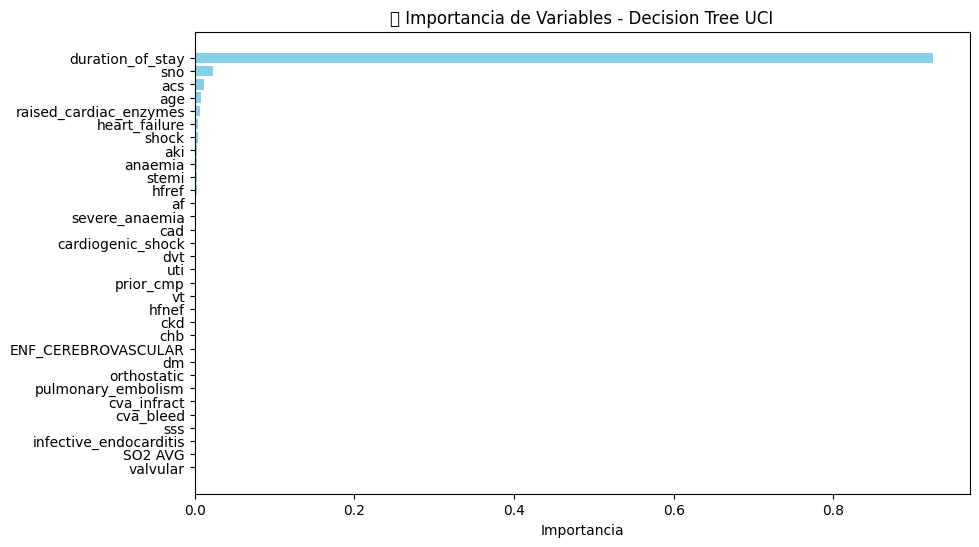

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Importancia de las variables
importances = best_tree.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Ordenar de mayor a menor importancia
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Mostrar tabla
print(feature_importance_df)

# Graficar
plt.figure(figsize=(10,6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # para que la variable más importante quede arriba
plt.xlabel('Importancia')
plt.title('🌳 Importancia de Variables - Decision Tree UCI')
plt.show()
